In [14]:
import pandas as pd
import numpy as np
np.seterr(all="raise")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [20]:
df = pd.read_parquet("out/2019-11-06-1d-train.parquet")

i = df.direct_time < 0
assert i.sum() == 65
df = df[~i]

i = df.fft_time <= 0
assert i.sum() == 76
df = df[~i]

In [21]:
df["h_nelement"] = df["h.shape[0]"]# * df["h.shape[1]"]
df["x_nelement"] = df["x.shape[0]"]# * df["x.shape[1]"]
df["log2(fft_time/direct_time)"] = np.log2(df.fft_time / df.direct_time)
df["log2(fft_time)"] = np.log2(df.fft_time)
df["log2(direct_time)"] = np.log2(df.direct_time)
df["fft_time/direct_time"] = df.fft_time / df.direct_time
df.tail()

,fft_time,direct_time,mode,x.shape[0],h.shape[0],random_state,h_nelement,x_nelement,log2(fft_time/direct_time),log2(fft_time),log2(direct_time),fft_time/direct_time
24495,0.004494,0.505727,full,49999,49999,24495,49999,49999,-6.814153,-7.797723,-0.983570,0.008887
24496,0.004696,0.000047,valid,49999,49999,24496,49999,49999,6.628917,-7.734458,-14.363375,98.969849
24497,0.004792,0.377170,same,49999,49999,24497,49999,49999,-6.298450,-7.705164,-1.406714,0.012705
24498,0.004652,0.375863,same,49999,49999,24498,49999,49999,-6.336205,-7.747926,-1.411721,0.012377
24499,0.000155,0.003725,same,159,2349,24499,2349,159,-4.582656,-12.651272,-8.068616,0.041733


In [22]:
df.direct_time.max()

32.231529235839844

In [23]:
df.fft_time.max()

0.004791975021362305

In [24]:
df.direct_time.max()

32.231529235839844

In [29]:
(df["mode"] == "same").sum() / len(df)

0.6000246315530194

# Visualize ratio

Text(0.5, 1, 'valid')

Text(0.5, 1, 'same')

Text(0.5, 1, 'full')

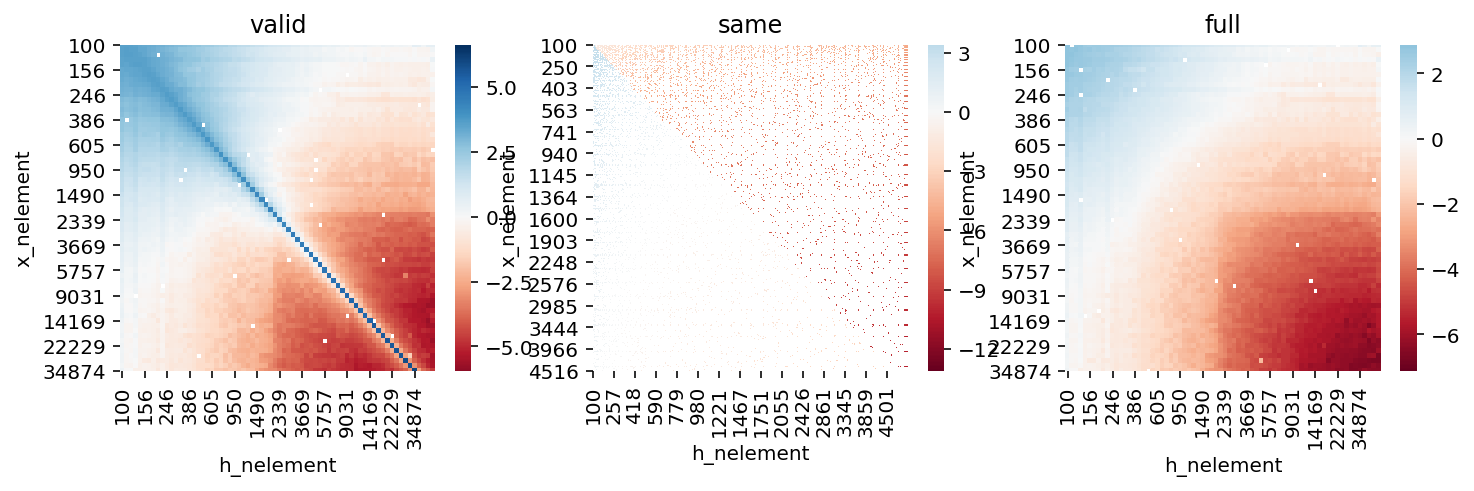

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

w = 3
fig, axs = plt.subplots(ncols=3, figsize=(4 * w, w))
for ax, mode in zip(axs, ["valid", "same", "full"]):
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    show = df[df["mode"] == mode].pivot_table(
        index="x_nelement",
        columns="h_nelement",
        values="log2(fft_time/direct_time)",
    )
    ax = sns.heatmap(
        show,
        center=0,
        ax=ax,
        cmap="RdBu",
    )
    ax.set_title(mode)

* Blue: direct faster
* Red: FFT faster

# Find big-O constant

In [30]:
from scipy.optimize import curve_fit
from toolz import partial
sum_builtin = sum

def _prod(iterable):
    """
    Product of a list of numbers.
    Faster than np.prod for short lists like array shapes.
    """
    product = 1
    for x in iterable:
        product *= x
    return product

def _fftconv_faster(x_shape, x_size, h_shape, h_size, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = min(x_size, h_size) * _prod(out_shape)
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    return fft_time, direct_time
    
def log_time(shapes, O, mode):
# def _fftconv_faster(shapes, O, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    times = []
    for shape in shapes:
        x_shape = np.array([shape[0]])
        h_shape = np.array([shape[1]])
        assert len(shape) == 2
        assert len(x_shape) == len(h_shape) == 1
        fft_time, direct_time = _fftconv_faster(
            x_shape, _prod(x_shape), h_shape, _prod(h_shape), mode,
        )
        times.append([fft_time, direct_time])
    times = np.asarray(times)
    fft_time = times[:, 0]
    direct_time = times[:, 1]
    diff = O * fft_time / direct_time
    
    power = np.log2(abs(diff))
    sign = np.sign(diff)
    return sign * power

def get_constant(df, mode):
    """
    Inputs
    ------
    df : DataFrame with columns x.shape[0], x.shape[1], h.shape[0], h.shape[1] and log2(fft_time/direct_time)
    
    Returns
    -------
    popt : float
        The constant such that constant * fft_time < direct_time
    pstd : float
        The (estimated) standard deviation of popt
    """
    shapes = df[["x.shape[0]", "h.shape[0]"]].values
    times = df["log2(fft_time/direct_time)"].values
    log_time_w_mode = partial(log_time, mode=mode)

#     p0s = {"full": 9e3, "same": 34e3, "valid": 66e3}
#     kwargs = {"p0": 2 * p0s[mode]}
#     kwargs = {"p0": 20e3}
    kwargs = {}
    popt, pcov = curve_fit(log_time_w_mode, shapes, times, **kwargs)
    O = popt.item()
    times_hat = log_time_w_mode(shapes, O)
    return O, np.sqrt(pcov).item(), (times_hat, times)

In [31]:
bigOs = []

In [32]:
for mode in ["valid", "full"]:
    idx = df["mode"] == mode
    if not idx.sum():
        continue
    fit = df[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, O, std)
    bigOs.append({"mode": mode, "constant": O, "std": std})

valid 14.336458082971573 0.13344469622829414
full 14.320593536430781 0.12286617653040303


In [33]:
mode = "same"
same = df[df["mode"] == mode].copy()
print(same.columns)

smaller_kernel = same.h_nelement < same.x_nelement
bigger_kernel = same.x_nelement <= same.h_nelement
for condition, idx in {"bigger_kernel": bigger_kernel, "smaller_kernel": smaller_kernel}.items():
    fit = same[idx].copy()
    O, std, times = get_constant(fit, mode)
    y_hat, y = times
    fit["predicted_ratio"] = y_hat
    print(mode, condition, O, std)
    bigOs.append({"mode": mode, "constant": O, "std": std, "cond": condition})

Index(['fft_time', 'direct_time', 'mode', 'x.shape[0]', 'h.shape[0]',
       'random_state', 'h_nelement', 'x_nelement',
       'log2(fft_time/direct_time)', 'log2(fft_time)', 'log2(direct_time)',
       'fft_time/direct_time'],
      dtype='object')
same bigger_kernel 0.08847913360539553 0.0018928499755570475
same smaller_kernel 18.060235190129017 0.1416212396715055


In [34]:
bigOs

[{'mode': 'valid', 'constant': 14.336458082971573, 'std': 0.13344469622829414},
 {'mode': 'full', 'constant': 14.320593536430781, 'std': 0.12286617653040303},
 {'mode': 'same',
  'constant': 0.08847913360539553,
  'std': 0.0018928499755570475,
  'cond': 'bigger_kernel'},
 {'mode': 'same',
  'constant': 18.060235190129017,
  'std': 0.1416212396715055,
  'cond': 'smaller_kernel'}]

In [35]:
constants = pd.DataFrame(bigOs)
constants["ndim"] = 1

In [36]:
constants

,mode,constant,std,cond,ndim
0,valid,14.336458,0.133445,NaN,1
1,full,14.320594,0.122866,NaN,1
2,same,0.088479,0.001893,bigger_kernel,1
3,same,18.060235,0.141621,smaller_kernel,1


In [37]:
constants["std"] / constants["constant"]

0    0.009308
1    0.008580
2    0.021393
3    0.007842
dtype: float64

In [38]:
constants.to_csv("constants.csv", index=False)
